# Heart Disease Prediction Analysis

## CS445 - Artificial Intelligence Project

This notebook follows the CRISP-DM methodology to build a heart disease prediction model using the UCI Cleveland Heart Disease dataset.

**Author:** Jaron Cabral, Hunter 
**Dataset:** UCI Cleveland Heart Disease Dataset (303 records, 14 attributes)

---
## 1. Business Understanding

Early detection of heart disease is extremely important because cardiovascular conditions often progress silently until they cause severe, sometimes fatal, events such as heart attacks or heart failure.

**Project Goals:**
- Identify which clinical and lifestyle indicators most strongly predict heart disease
- Build and compare tree-based models (Decision Tree and Random Forest) to classify patients into "disease" vs "no disease" categories
- Design a user-friendly Heart Risk Advisor that turns model outputs into understandable, educational feedback for non-experts

**Target Users:**
- Primary care providers seeking data-driven cardiovascular risk assessment tools
- Individuals who want a snapshot of their cardiovascular risk profile

---
## 2. Data Understanding

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import joblib

# Advanced ML libraries
import xgboost as xgb
import lightgbm as lgb
import optuna
from optuna.samplers import TPESampler
import shap
from imblearn.over_sampling import SMOTE
from scipy import stats
import time

import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("All libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"SHAP version: {shap.__version__}")

/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully!
XGBoost version: 3.1.2
LightGBM version: 4.6.0
SHAP version: 0.49.1


In [2]:
# Define column names for the Cleveland dataset
column_names = [
    'age',       # Age in years
    'sex',       # Sex (1 = male, 0 = female)
    'cp',        # Chest pain type (1-4)
    'trestbps',  # Resting blood pressure (mm Hg)
    'chol',      # Serum cholesterol (mg/dl)
    'fbs',       # Fasting blood sugar > 120 mg/dl (1 = true, 0 = false)
    'restecg',   # Resting ECG results (0-2)
    'thalach',   # Maximum heart rate achieved
    'exang',     # Exercise induced angina (1 = yes, 0 = no)
    'oldpeak',   # ST depression induced by exercise
    'slope',     # Slope of peak exercise ST segment (1-3)
    'ca',        # Number of major vessels colored by fluoroscopy (0-3)
    'thal',      # Thalassemia (3 = normal, 6 = fixed defect, 7 = reversible defect)
    'target'     # Heart disease (0 = no disease, 1-4 = disease severity)
]

# Load the dataset
df = pd.read_csv('processed.cleveland.data', names=column_names, na_values='?')

print(f"Dataset Shape: {df.shape}")
print(f"Number of records: {len(df)}")
print(f"Number of features: {len(df.columns) - 1}")

Dataset Shape: (303, 14)
Number of records: 303
Number of features: 13


In [3]:
# Display first few rows
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


In [4]:
# Check data types and missing values
print("Data Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

Data Types:
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
target        int64
dtype: object

Missing Values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


In [5]:
# Summary statistics
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [6]:
# Target distribution (before binarization)
print("Target Variable Distribution (Original):")
print(df['target'].value_counts().sort_index())

Target Variable Distribution (Original):
target
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64


### Interactive Visualizations (Plotly)

In [7]:
# VISUALIZATION 1: Correlation Heatmap
# Create a copy for visualization (handle missing values first)
df_viz = df.copy()
df_viz['ca'] = df_viz['ca'].fillna(df_viz['ca'].mode()[0])
df_viz['thal'] = df_viz['thal'].fillna(df_viz['thal'].mode()[0])
df_viz['disease'] = (df_viz['target'] > 0).astype(int)  # Binarize for visualization

# Calculate correlation matrix
corr_matrix = df_viz.drop('target', axis=1).corr()

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='RdBu_r',
    zmid=0,
    text=np.round(corr_matrix.values, 2),
    texttemplate='%{text}',
    textfont={"size": 10},
    hoverongaps=False
))

fig.update_layout(
    title='Feature Correlation Heatmap',
    width=800,
    height=700,
    xaxis_title='Features',
    yaxis_title='Features'
)

fig.show()

In [8]:
# VISUALIZATION 2: Box Plots - Key Features by Disease Status
df_viz['Disease Status'] = df_viz['disease'].map({0: 'No Disease', 1: 'Disease'})

fig = make_subplots(rows=2, cols=2, subplot_titles=(
    'Cholesterol by Disease Status',
    'Resting Blood Pressure by Disease Status',
    'Max Heart Rate by Disease Status',
    'ST Depression (oldpeak) by Disease Status'
))

# Cholesterol
for status, color in [('No Disease', '#2ecc71'), ('Disease', '#e74c3c')]:
    data = df_viz[df_viz['Disease Status'] == status]['chol']
    fig.add_trace(go.Box(y=data, name=status, marker_color=color, showlegend=True), row=1, col=1)

# Resting Blood Pressure
for status, color in [('No Disease', '#2ecc71'), ('Disease', '#e74c3c')]:
    data = df_viz[df_viz['Disease Status'] == status]['trestbps']
    fig.add_trace(go.Box(y=data, name=status, marker_color=color, showlegend=False), row=1, col=2)

# Max Heart Rate
for status, color in [('No Disease', '#2ecc71'), ('Disease', '#e74c3c')]:
    data = df_viz[df_viz['Disease Status'] == status]['thalach']
    fig.add_trace(go.Box(y=data, name=status, marker_color=color, showlegend=False), row=2, col=1)

# ST Depression
for status, color in [('No Disease', '#2ecc71'), ('Disease', '#e74c3c')]:
    data = df_viz[df_viz['Disease Status'] == status]['oldpeak']
    fig.add_trace(go.Box(y=data, name=status, marker_color=color, showlegend=False), row=2, col=2)

fig.update_layout(
    title='Distribution of Key Features by Disease Status',
    height=700,
    width=900
)

fig.show()

In [9]:
# VISUALIZATION 3: Distribution of Key Features (Histograms)
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    'Age Distribution',
    'Cholesterol Distribution',
    'Max Heart Rate Distribution',
    'ST Depression Distribution'
))

# Age
fig.add_trace(go.Histogram(x=df_viz['age'], nbinsx=20, name='Age', marker_color='#3498db'), row=1, col=1)

# Cholesterol
fig.add_trace(go.Histogram(x=df_viz['chol'], nbinsx=20, name='Cholesterol', marker_color='#9b59b6'), row=1, col=2)

# Max Heart Rate
fig.add_trace(go.Histogram(x=df_viz['thalach'], nbinsx=20, name='Max HR', marker_color='#e67e22'), row=2, col=1)

# ST Depression
fig.add_trace(go.Histogram(x=df_viz['oldpeak'], nbinsx=20, name='ST Depression', marker_color='#1abc9c'), row=2, col=2)

fig.update_layout(
    title='Distribution of Key Numeric Features',
    height=600,
    width=900,
    showlegend=False
)

fig.show()

In [10]:
# VISUALIZATION 4: Categorical Features Analysis
# Sex distribution by disease status
sex_disease = df_viz.groupby(['sex', 'Disease Status']).size().reset_index(name='count')
sex_disease['Sex'] = sex_disease['sex'].map({0: 'Female', 1: 'Male'})

fig1 = px.bar(sex_disease, x='Sex', y='count', color='Disease Status',
              barmode='group', title='Disease Distribution by Sex',
              color_discrete_map={'No Disease': '#2ecc71', 'Disease': '#e74c3c'})
fig1.update_layout(width=600, height=400)
fig1.show()

In [11]:
# Chest Pain Type distribution
cp_labels = {1: 'Typical Angina', 2: 'Atypical Angina', 3: 'Non-anginal Pain', 4: 'Asymptomatic'}
cp_disease = df_viz.groupby(['cp', 'Disease Status']).size().reset_index(name='count')
cp_disease['Chest Pain Type'] = cp_disease['cp'].map(cp_labels)

fig2 = px.bar(cp_disease, x='Chest Pain Type', y='count', color='Disease Status',
              barmode='group', title='Disease Distribution by Chest Pain Type',
              color_discrete_map={'No Disease': '#2ecc71', 'Disease': '#e74c3c'})
fig2.update_layout(width=700, height=400)
fig2.show()

---
## 3. Data Preparation

In [12]:
# Create a clean copy for modeling
df_model = df.copy()

print("Missing values before handling:")
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])

Missing values before handling:
ca      4
thal    2
dtype: int64


In [13]:
# Handle missing values
# Using mode imputation for 'ca' and 'thal' as they are categorical features

print("Mode of 'ca':", df_model['ca'].mode()[0])
print("Mode of 'thal':", df_model['thal'].mode()[0])

df_model['ca'] = df_model['ca'].fillna(df_model['ca'].mode()[0])
df_model['thal'] = df_model['thal'].fillna(df_model['thal'].mode()[0])

print("\nMissing values after handling:")
print(df_model.isnull().sum().sum())

Mode of 'ca': 0.0
Mode of 'thal': 3.0

Missing values after handling:
0


In [14]:
# Binarize target variable
# Original: 0 = no disease, 1-4 = increasing severity
# Binarized: 0 = no disease, 1 = disease (any severity)

print("Original target distribution:")
print(df_model['target'].value_counts().sort_index())

df_model['target'] = (df_model['target'] > 0).astype(int)

print("\nBinarized target distribution:")
print(df_model['target'].value_counts())
print(f"\nDisease rate: {df_model['target'].mean()*100:.1f}%")

Original target distribution:
target
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

Binarized target distribution:
target
0    164
1    139
Name: count, dtype: int64

Disease rate: 45.9%


In [15]:
# Separate features and target
X = df_model.drop('target', axis=1)
y = df_model['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names: {list(X.columns)}")

Features shape: (303, 13)
Target shape: (303,)

Feature names: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [16]:
# Train/Test Split (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.0f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.0f}%)")
print(f"\nTraining disease rate: {y_train.mean()*100:.1f}%")
print(f"Test disease rate: {y_test.mean()*100:.1f}%")

Training set size: 242 (80%)
Test set size: 61 (20%)

Training disease rate: 45.9%
Test disease rate: 45.9%


In [17]:
def engineer_features(df):
    """
    Create advanced domain-specific features for heart disease prediction.
    These features are based on medical knowledge and clinical risk factors.
    """
    df = df.copy()
    
    # === Cardiac Efficiency Metrics ===
    df['cardiac_efficiency'] = df['thalach'] / df['trestbps']
    df['heart_rate_reserve'] = (220 - df['age']) - df['thalach']
    df['age_adjusted_hr'] = df['thalach'] / (220 - df['age'])
    
    # === Risk Interaction Features ===
    df['age_chol_risk'] = df['age'] * df['chol'] / 1000
    df['age_bp_risk'] = df['age'] * df['trestbps'] / 1000
    df['metabolic_risk'] = (df['chol'] / 200) + (df['trestbps'] / 120) + df['fbs']
    
    # === ST Depression Analysis ===
    df['st_severity'] = df['oldpeak'] * (df['slope'] + 1)
    df['exercise_stress_index'] = df['oldpeak'] * df['exang'] + (df['oldpeak'] ** 2)
    
    # === Vessel Disease Indicators ===
    df['vessel_severity'] = df['ca'] * df['thal'] / 3
    
    # === Binary Risk Flags ===
    df['high_chol'] = (df['chol'] > 240).astype(int)
    df['high_bp'] = (df['trestbps'] > 140).astype(int)
    df['low_hr_reserve'] = (df['heart_rate_reserve'] > 50).astype(int)
    df['asymptomatic_cp'] = (df['cp'] == 4).astype(int)
    
    return df

# Apply feature engineering
X_train_eng = engineer_features(X_train)
X_test_eng = engineer_features(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Engineered features: {X_train_eng.shape[1]}")
print(f"\nNew features added:")
for feat in [c for c in X_train_eng.columns if c not in X_train.columns]:
    print(f"  - {feat}")

Original features: 13
Engineered features: 26

New features added:
  - cardiac_efficiency
  - heart_rate_reserve
  - age_adjusted_hr
  - age_chol_risk
  - age_bp_risk
  - metabolic_risk
  - st_severity
  - exercise_stress_index
  - vessel_severity
  - high_chol
  - high_bp
  - low_hr_reserve
  - asymptomatic_cp


In [18]:
# Apply SMOTE for class balancing (on training data only)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_eng, y_train)

print(f"Original training set: {len(X_train_eng)} samples")
print(f"After SMOTE: {len(X_train_balanced)} samples")
print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Original training set: 242 samples
After SMOTE: 262 samples

Class distribution after SMOTE:
target
1    131
0    131
Name: count, dtype: int64


### Advanced Feature Engineering

Creating domain-specific medical features to improve model accuracy. These engineered features capture clinically meaningful relationships between variables.

### Data Preparation Summary

**Missing Values:**
- `ca` (major vessels): 4 missing values → filled with mode (0.0)
- `thal` (thalassemia): 2 missing values → filled with mode (3.0)
- **Rationale:** Mode imputation preserves the distribution for categorical features

**Categorical Encoding:**
- Features are already numerically encoded in the dataset
- `sex`: 0/1 (female/male)
- `cp`, `restecg`, `slope`, `thal`: ordinal integers preserved

**Target Binarization:**
- Original: 0 (no disease), 1-4 (disease severity levels)
- Binarized: 0 (no disease), 1 (any disease)

**Scaling:**
- NOT applied (tree-based models don't require scaled features)

---
## 4. Modeling

In [19]:
# Default Decision Tree (using engineered features)
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train_eng, y_train)

# Predictions
y_pred_dt_default = dt_default.predict(X_test_eng)

# Metrics
dt_default_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_dt_default),
    'precision': precision_score(y_test, y_pred_dt_default),
    'recall': recall_score(y_test, y_pred_dt_default),
    'f1': f1_score(y_test, y_pred_dt_default)
}

print("Decision Tree (Default) Performance:")
for metric, value in dt_default_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

Decision Tree (Default) Performance:
  Accuracy: 0.6557
  Precision: 0.6000
  Recall: 0.7500
  F1: 0.6667


In [20]:
# Tuned Decision Tree (tuning max_depth) with engineered features
param_grid_dt = {'max_depth': [3, 5, 7, 10, 15, None]}

grid_search_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='f1',
    return_train_score=True
)
grid_search_dt.fit(X_train_eng, y_train)

print("Decision Tree Hyperparameter Tuning Results:")
print(f"Best parameters: {grid_search_dt.best_params_}")
print(f"Best CV F1 score: {grid_search_dt.best_score_:.4f}")

Decision Tree Hyperparameter Tuning Results:
Best parameters: {'max_depth': 5}
Best CV F1 score: 0.7010


In [21]:
# Evaluate tuned Decision Tree
dt_tuned = grid_search_dt.best_estimator_
y_pred_dt_tuned = dt_tuned.predict(X_test_eng)

dt_tuned_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_dt_tuned),
    'precision': precision_score(y_test, y_pred_dt_tuned),
    'recall': recall_score(y_test, y_pred_dt_tuned),
    'f1': f1_score(y_test, y_pred_dt_tuned)
}

print("Decision Tree (Tuned) Performance:")
for metric, value in dt_tuned_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

Decision Tree (Tuned) Performance:
  Accuracy: 0.7049
  Precision: 0.6786
  Recall: 0.6786
  F1: 0.6786


In [22]:
# Decision Tree Feature Importance (with engineered features)
dt_importance = pd.DataFrame({
    'feature': X_train_eng.columns,
    'importance': dt_tuned.feature_importances_
}).sort_values('importance', ascending=True)

fig = px.bar(dt_importance.tail(15), x='importance', y='feature', orientation='h',
             title='Decision Tree (Tuned) - Top 15 Feature Importance',
             labels={'importance': 'Importance', 'feature': 'Feature'},
             color='importance', color_continuous_scale='Viridis')
fig.update_layout(height=500, width=700, showlegend=False)
fig.show()

In [23]:
# Tuned Random Forest (with engineered features)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='f1',
    return_train_score=True
)
grid_search_rf.fit(X_train_eng, y_train)

print("Random Forest Hyperparameter Tuning Results:")
print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best CV F1 score: {grid_search_rf.best_score_:.4f}")

Random Forest Hyperparameter Tuning Results:
Best parameters: {'max_depth': 5, 'n_estimators': 50}
Best CV F1 score: 0.8068


In [24]:
# Evaluate tuned Random Forest
rf_tuned = grid_search_rf.best_estimator_
y_pred_rf = rf_tuned.predict(X_test_eng)

rf_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf)
}

print("Random Forest (Tuned) Performance:")
for metric, value in rf_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

Random Forest (Tuned) Performance:
  Accuracy: 0.9016
  Precision: 0.8929
  Recall: 0.8929
  F1: 0.8929


In [25]:
# Random Forest Feature Importance (with engineered features)
rf_importance = pd.DataFrame({
    'feature': X_train_eng.columns,
    'importance': rf_tuned.feature_importances_
}).sort_values('importance', ascending=True)

fig = px.bar(rf_importance.tail(15), x='importance', y='feature', orientation='h',
             title='Random Forest (Tuned) - Top 15 Feature Importance',
             labels={'importance': 'Importance', 'feature': 'Feature'},
             color='importance', color_continuous_scale='Plasma')
fig.update_layout(height=500, width=700, showlegend=False)
fig.show()

In [26]:
# XGBoost with GridSearchCV
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

start_time = time.time()
grid_search_xgb = GridSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    param_grid_xgb,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_search_xgb.fit(X_train_eng, y_train)
xgb_train_time = time.time() - start_time

print("XGBoost Hyperparameter Tuning Results:")
print(f"Best parameters: {grid_search_xgb.best_params_}")
print(f"Best CV F1 score: {grid_search_xgb.best_score_:.4f}")
print(f"Training time: {xgb_train_time:.2f}s")

/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/xgboost/training.py:199: UserWarning: [13:32:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/xgboost/training.py:199: UserWarning: [13:32:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/xgboost/training.py:199: UserWarning: [13:32:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/xgboost/training.py:199: UserWarning: [13:32:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Par

XGBoost Hyperparameter Tuning Results:
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best CV F1 score: 0.8083
Training time: 3.01s


/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/xgboost/training.py:199: UserWarning: [13:32:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/xgboost/training.py:199: UserWarning: [13:32:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/xgboost/training.py:199: UserWarning: [13:32:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [27]:
# Evaluate XGBoost
xgb_tuned = grid_search_xgb.best_estimator_
y_pred_xgb = xgb_tuned.predict(X_test_eng)

xgb_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb),
    'recall': recall_score(y_test, y_pred_xgb),
    'f1': f1_score(y_test, y_pred_xgb)
}

print("XGBoost (Tuned) Performance:")
for metric, value in xgb_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

XGBoost (Tuned) Performance:
  Accuracy: 0.8852
  Precision: 0.8387
  Recall: 0.9286
  F1: 0.8814


### Model 4: LightGBM Classifier

LightGBM is a fast, distributed gradient boosting framework that uses leaf-wise tree growth, making it particularly efficient for larger datasets.

In [28]:
# LightGBM with GridSearchCV
param_grid_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 63]
}

start_time = time.time()
grid_search_lgb = GridSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1),
    param_grid_lgb,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_search_lgb.fit(X_train_eng, y_train)
lgb_train_time = time.time() - start_time

print("LightGBM Hyperparameter Tuning Results:")
print(f"Best parameters: {grid_search_lgb.best_params_}")
print(f"Best CV F1 score: {grid_search_lgb.best_score_:.4f}")
print(f"Training time: {lgb_train_time:.2f}s")

LightGBM Hyperparameter Tuning Results:
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 15}
Best CV F1 score: 0.7957
Training time: 23.83s


In [29]:
# Evaluate LightGBM
lgb_tuned = grid_search_lgb.best_estimator_
y_pred_lgb = lgb_tuned.predict(X_test_eng)

lgb_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_lgb),
    'precision': precision_score(y_test, y_pred_lgb),
    'recall': recall_score(y_test, y_pred_lgb),
    'f1': f1_score(y_test, y_pred_lgb)
}

print("LightGBM (Tuned) Performance:")
for metric, value in lgb_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

LightGBM (Tuned) Performance:
  Accuracy: 0.8852
  Precision: 0.8387
  Recall: 0.9286
  F1: 0.8814


### Model 5: Stacking Ensemble

Stacking combines predictions from multiple base models using a meta-learner. This approach leverages the strengths of different algorithms to achieve superior performance.

In [30]:
# Stacking Ensemble with best models
start_time = time.time()

stacking_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                                   random_state=42, eval_metric='logloss', use_label_encoder=False)),
        ('lgb', lgb.LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                                    random_state=42, verbose=-1))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train_eng, y_train)
stacking_train_time = time.time() - start_time

print(f"Stacking Ensemble trained successfully!")
print(f"Training time: {stacking_train_time:.2f}s")

/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/xgboost/training.py:199: UserWarning: [13:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[13:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

[13:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

[13:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

[13:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

[13:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.



Stacking Ensemble trained successfully!
Training time: 0.83s


In [31]:
# Evaluate Stacking Ensemble
y_pred_stack = stacking_model.predict(X_test_eng)

stacking_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_stack),
    'precision': precision_score(y_test, y_pred_stack),
    'recall': recall_score(y_test, y_pred_stack),
    'f1': f1_score(y_test, y_pred_stack)
}

print("Stacking Ensemble Performance:")
for metric, value in stacking_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

Stacking Ensemble Performance:
  Accuracy: 0.8852
  Precision: 0.8182
  Recall: 0.9643
  F1: 0.8852


### Optuna Bayesian Hyperparameter Optimization

Optuna uses Bayesian optimization (TPE sampler) to efficiently search the hyperparameter space, finding better parameters with fewer trials than grid search.

In [32]:
# Optuna Bayesian Optimization for XGBoost
def optuna_xgb_objective(trial):
    """Objective function for Optuna to optimize XGBoost hyperparameters."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
    }
    
    model = xgb.XGBClassifier(**params, random_state=42, eval_metric='logloss', use_label_encoder=False)
    scores = cross_val_score(model, X_train_eng, y_train, cv=5, scoring='f1')
    return scores.mean()

# Run Optuna study
print("Running Optuna Bayesian Optimization (15 trials)...")
start_time = time.time()

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(optuna_xgb_objective, n_trials=15, show_progress_bar=True)

optuna_time = time.time() - start_time

print(f"\nOptuna Optimization Complete!")
print(f"Time: {optuna_time:.2f}s")
print(f"Best F1 Score: {study.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Running Optuna Bayesian Optimization (15 trials)...


Best trial: 10. Best value: 0.802867: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Optuna Optimization Complete!
Time: 5.91s
Best F1 Score: 0.8029

Best Hyperparameters:
  n_estimators: 273
  max_depth: 3
  learning_rate: 0.11693134408911823
  subsample: 0.6071847502459278
  colsample_bytree: 0.993065495809967
  gamma: 2.1124553221013826
  reg_alpha: 0.031189599316912786
  reg_lambda: 0.02461509550020735


In [33]:
# Train and evaluate Optuna-optimized XGBoost
xgb_optuna = xgb.XGBClassifier(**study.best_params, random_state=42, eval_metric='logloss', use_label_encoder=False)
xgb_optuna.fit(X_train_eng, y_train)
y_pred_xgb_optuna = xgb_optuna.predict(X_test_eng)

xgb_optuna_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_xgb_optuna),
    'precision': precision_score(y_test, y_pred_xgb_optuna),
    'recall': recall_score(y_test, y_pred_xgb_optuna),
    'f1': f1_score(y_test, y_pred_xgb_optuna)
}

print("XGBoost (Optuna-Optimized) Performance:")
for metric, value in xgb_optuna_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

XGBoost (Optuna-Optimized) Performance:
  Accuracy: 0.8689
  Precision: 0.8125
  Recall: 0.9286
  F1: 0.8667


In [34]:
# Visualize Optuna optimization history
trials_df = study.trials_dataframe()
fig = px.line(trials_df, x='number', y='value', 
              title='Optuna Optimization History',
              labels={'number': 'Trial Number', 'value': 'F1 Score (CV)'})
fig.add_hline(y=study.best_value, line_dash="dash", line_color="red", 
              annotation_text=f"Best: {study.best_value:.4f}")
fig.update_layout(height=400, width=700)
fig.show()

In [35]:
# SHAP Analysis for the best model
# Using XGBoost Optuna as the best model for SHAP analysis

print("Computing SHAP values...")

import shap
shap.initjs()

# Use KernelExplainer as a workaround for XGBoost/SHAP version compatibility
# Sample background data for efficiency
background = shap.sample(X_train_eng, 50, random_state=42)

# Create a prediction function wrapper
def model_predict(X):
    return xgb_optuna.predict_proba(X)[:, 1]

# Use KernelExplainer
explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(X_test_eng[:20])  # Use subset for speed

print(f"SHAP values computed for 20 test samples")
print(f"Number of features: {X_test_eng.shape[1]}")

Computing SHAP values...


100%|██████████| 20/20 [00:01<00:00, 13.43it/s]

SHAP values computed for 20 test samples
Number of features: 26


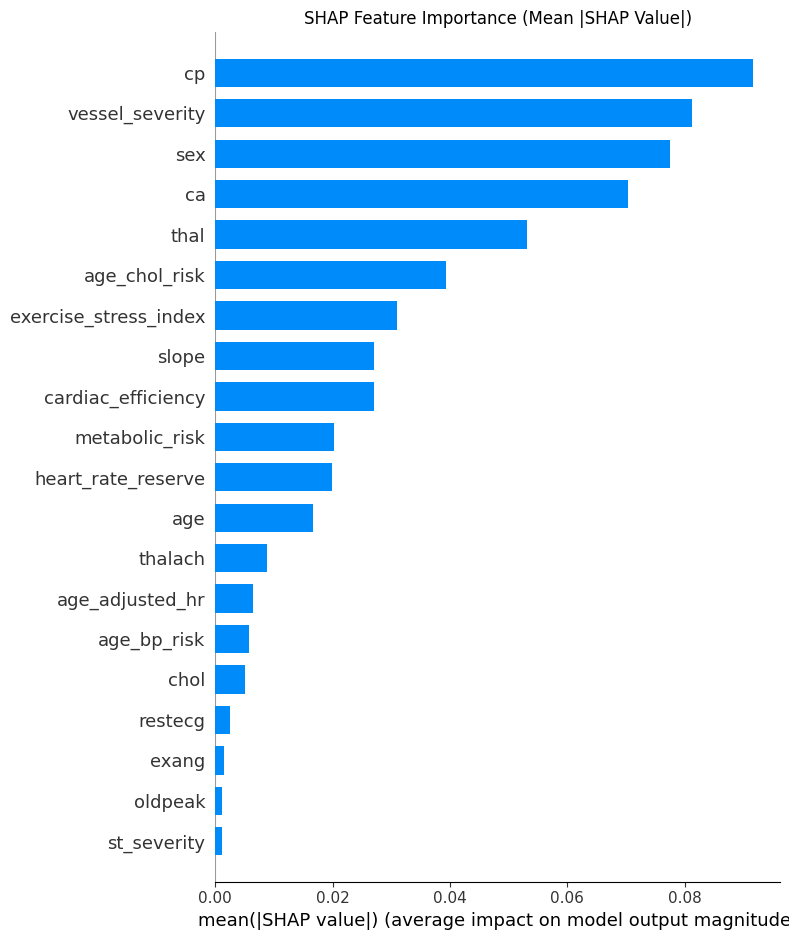

SHAP bar plot saved as 'shap_bar_plot.png'


In [36]:
# SHAP Summary Plot - Feature Importance (Bar)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_eng[:20], plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean |SHAP Value|)")
plt.tight_layout()
plt.savefig('shap_bar_plot.png', dpi=150, bbox_inches='tight')
plt.show()
print("SHAP bar plot saved as 'shap_bar_plot.png'")

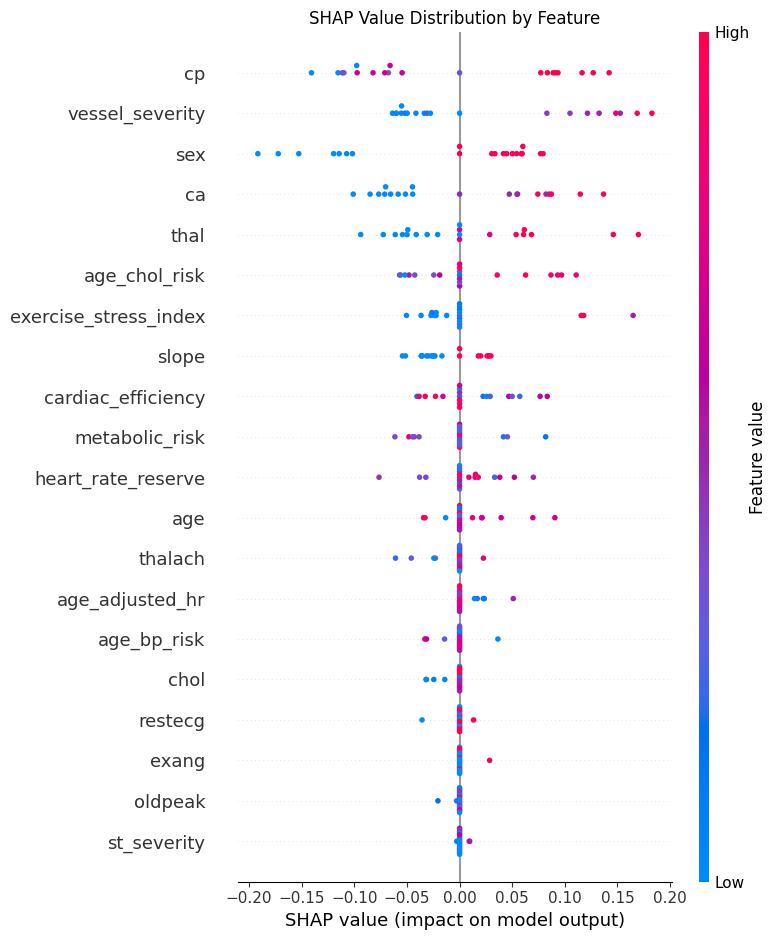

SHAP beeswarm plot saved as 'shap_beeswarm_plot.png'


In [37]:
# SHAP Summary Plot - Beeswarm (shows feature value impact)
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_eng[:20], show=False)
plt.title("SHAP Value Distribution by Feature")
plt.tight_layout()
plt.savefig('shap_beeswarm_plot.png', dpi=150, bbox_inches='tight')
plt.show()
print("SHAP beeswarm plot saved as 'shap_beeswarm_plot.png'")

### Nested Cross-Validation & Statistical Confidence

Nested cross-validation provides unbiased estimates of model performance. We also compute confidence intervals to quantify uncertainty in our metrics.

In [38]:
# Nested Cross-Validation for best model
print("Running 10-fold Nested Cross-Validation...")

# Apply feature engineering to full dataset
X_full_eng = engineer_features(X)

outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Nested CV scores
nested_scores_f1 = cross_val_score(xgb_optuna, X_full_eng, y, cv=outer_cv, scoring='f1')
nested_scores_acc = cross_val_score(xgb_optuna, X_full_eng, y, cv=outer_cv, scoring='accuracy')
nested_scores_auc = cross_val_score(xgb_optuna, X_full_eng, y, cv=outer_cv, scoring='roc_auc')

print(f"\nNested Cross-Validation Results (10-fold):")
print(f"  F1 Score:  {nested_scores_f1.mean():.4f} (+/- {nested_scores_f1.std()*2:.4f})")
print(f"  Accuracy:  {nested_scores_acc.mean():.4f} (+/- {nested_scores_acc.std()*2:.4f})")
print(f"  ROC-AUC:   {nested_scores_auc.mean():.4f} (+/- {nested_scores_auc.std()*2:.4f})")

Running 10-fold Nested Cross-Validation...

Nested Cross-Validation Results (10-fold):
  F1 Score:  0.7852 (+/- 0.1037)
  Accuracy:  0.8083 (+/- 0.0932)
  ROC-AUC:   0.8820 (+/- 0.1051)


In [39]:
# 95% Confidence Intervals
def compute_confidence_interval(scores, confidence=0.95):
    """Compute confidence interval using t-distribution."""
    n = len(scores)
    mean = scores.mean()
    se = stats.sem(scores)
    ci = stats.t.interval(confidence, n-1, loc=mean, scale=se)
    return mean, ci[0], ci[1]

print("95% Confidence Intervals:")
for metric, scores in [('F1 Score', nested_scores_f1), 
                       ('Accuracy', nested_scores_acc), 
                       ('ROC-AUC', nested_scores_auc)]:
    mean, lower, upper = compute_confidence_interval(scores)
    print(f"  {metric}: {mean:.4f} [{lower:.4f}, {upper:.4f}]")

95% Confidence Intervals:
  F1 Score: 0.7852 [0.7461, 0.8243]
  Accuracy: 0.8083 [0.7731, 0.8434]
  ROC-AUC: 0.8820 [0.8424, 0.9217]


In [40]:
# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    xgb_optuna, X_full_eng, y, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Plot learning curve with Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=train_sizes, y=train_mean,
    mode='lines+markers',
    name='Training Score',
    line=dict(color='blue'),
    error_y=dict(type='data', array=train_std, visible=True)
))

fig.add_trace(go.Scatter(
    x=train_sizes, y=test_mean,
    mode='lines+markers',
    name='Validation Score',
    line=dict(color='red'),
    error_y=dict(type='data', array=test_std, visible=True)
))

fig.update_layout(
    title='Learning Curve - XGBoost (Optuna-Optimized)',
    xaxis_title='Training Set Size',
    yaxis_title='F1 Score',
    height=500,
    width=700,
    yaxis_range=[0.5, 1.0]
)

fig.show()

print("\nLearning Curve Analysis:")
print(f"  Final Training Score: {train_mean[-1]:.4f}")
print(f"  Final Validation Score: {test_mean[-1]:.4f}")
print(f"  Gap (potential overfitting): {train_mean[-1] - test_mean[-1]:.4f}")

/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/xgboost/training.py:199: UserWarning: [13:33:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/xgboost/training.py:199: UserWarning: [13:33:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/xgboost/training.py:199: UserWarning: [13:33:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jaroncabral/Library/Python/3.10/lib/python/site-packages/xgboost/training.py:199: UserWarning: [13:33:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Par


Learning Curve Analysis:
  Final Training Score: 0.9629
  Final Validation Score: 0.7903
  Gap (potential overfitting): 0.1726


### Model 3: XGBoost Classifier

XGBoost (eXtreme Gradient Boosting) is a powerful ensemble learning algorithm that builds trees sequentially, with each tree correcting errors from previous trees.

In [41]:
# Create comprehensive comparison table for all models
all_models_metrics = [
    ('Decision Tree (Default)', dt_default_metrics),
    ('Decision Tree (Tuned)', dt_tuned_metrics),
    ('Random Forest (Tuned)', rf_metrics),
    ('XGBoost (Tuned)', xgb_metrics),
    ('LightGBM (Tuned)', lgb_metrics),
    ('Stacking Ensemble', stacking_metrics),
    ('XGBoost (Optuna)', xgb_optuna_metrics)
]

comparison_df = pd.DataFrame({
    'Model': [m[0] for m in all_models_metrics],
    'Accuracy': [m[1]['accuracy'] for m in all_models_metrics],
    'Precision': [m[1]['precision'] for m in all_models_metrics],
    'Recall': [m[1]['recall'] for m in all_models_metrics],
    'F1 Score': [m[1]['f1'] for m in all_models_metrics]
})

# Add ROC-AUC scores
roc_auc_scores = []
models_for_auc = [
    ('Decision Tree (Default)', dt_default),
    ('Decision Tree (Tuned)', dt_tuned),
    ('Random Forest (Tuned)', rf_tuned),
    ('XGBoost (Tuned)', xgb_tuned),
    ('LightGBM (Tuned)', lgb_tuned),
    ('Stacking Ensemble', stacking_model),
    ('XGBoost (Optuna)', xgb_optuna)
]

for name, model in models_for_auc:
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_eng)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        roc_auc_scores.append(auc)
    else:
        roc_auc_scores.append(None)

comparison_df['ROC-AUC'] = roc_auc_scores

# Sort by F1 Score
comparison_df = comparison_df.sort_values('F1 Score', ascending=False)

# Format numeric columns
display_df = comparison_df.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']:
    display_df[col] = display_df[col].apply(lambda x: f'{x:.4f}' if x is not None else 'N/A')

display_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
2,Random Forest (Tuned),0.9016,0.8929,0.8929,0.8929,0.9502
5,Stacking Ensemble,0.8852,0.8182,0.9643,0.8852,0.9545
3,XGBoost (Tuned),0.8852,0.8387,0.9286,0.8814,0.9459
4,LightGBM (Tuned),0.8852,0.8387,0.9286,0.8814,0.9567
6,XGBoost (Optuna),0.8689,0.8125,0.9286,0.8667,0.9470
1,Decision Tree (Tuned),0.7049,0.6786,0.6786,0.6786,0.6196
0,Decision Tree (Default),0.6557,0.6000,0.7500,0.6667,0.6629


In [42]:
# Visual comparison of all models
metrics_data = []
for model_name, metrics in all_models_metrics:
    for metric_name in ['accuracy', 'precision', 'recall', 'f1']:
        metrics_data.append({
            'Model': model_name,
            'Metric': metric_name.capitalize() if metric_name != 'f1' else 'F1 Score',
            'Value': metrics[metric_name]
        })

metrics_df = pd.DataFrame(metrics_data)

fig = px.bar(metrics_df, x='Metric', y='Value', color='Model', barmode='group',
             title='Model Performance Comparison (7 Models)',
             color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_layout(height=500, width=1000, yaxis_range=[0, 1])
fig.show()

### Confusion Matrices

Confusion matrices show the exact counts of true positives, true negatives, false positives, and false negatives for each model.

In [43]:
# ROC Curves for all models
models_for_roc = [
    ('Decision Tree (Default)', dt_default),
    ('Decision Tree (Tuned)', dt_tuned),
    ('Random Forest (Tuned)', rf_tuned),
    ('XGBoost (Tuned)', xgb_tuned),
    ('LightGBM (Tuned)', lgb_tuned),
    ('Stacking Ensemble', stacking_model),
    ('XGBoost (Optuna)', xgb_optuna)
]

fig = go.Figure()
auc_scores = {}

colors = px.colors.qualitative.Set2

for i, (name, model) in enumerate(models_for_roc):
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_eng)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_scores[name] = auc
        
        fig.add_trace(go.Scatter(
            x=fpr, y=tpr,
            name=f'{name} (AUC = {auc:.4f})',
            mode='lines',
            line=dict(color=colors[i % len(colors)])
        ))

# Add diagonal reference line
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    name='Random Classifier',
    mode='lines',
    line=dict(dash='dash', color='gray')
))

fig.update_layout(
    title='ROC Curves Comparison (All Models)',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=800,
    height=600,
    legend=dict(x=0.5, y=0.1)
)

fig.show()

# Print AUC scores sorted by performance
print("\nROC-AUC Scores (sorted):")
for name, auc in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name}: {auc:.4f}")


ROC-AUC Scores (sorted):
  LightGBM (Tuned): 0.9567
  Stacking Ensemble: 0.9545
  Random Forest (Tuned): 0.9502
  XGBoost (Optuna): 0.9470
  XGBoost (Tuned): 0.9459
  Decision Tree (Default): 0.6629
  Decision Tree (Tuned): 0.6196


### SHAP Explainability

SHAP (SHapley Additive exPlanations) provides interpretable explanations for model predictions. This is critical for medical AI applications where understanding *why* a prediction was made is as important as the prediction itself.

### ROC Curves and AUC Scores

ROC (Receiver Operating Characteristic) curves show the trade-off between true positive rate and false positive rate at various classification thresholds. AUC (Area Under Curve) provides a single metric for overall model discrimination ability.

In [44]:
# Determine best model based on F1 score
models = {
    'Decision Tree (Default)': (dt_default, dt_default_metrics['f1']),
    'Decision Tree (Tuned)': (dt_tuned, dt_tuned_metrics['f1']),
    'Random Forest (Tuned)': (rf_tuned, rf_metrics['f1']),
    'XGBoost (Tuned)': (xgb_tuned, xgb_metrics['f1']),
    'LightGBM (Tuned)': (lgb_tuned, lgb_metrics['f1']),
    'Stacking Ensemble': (stacking_model, stacking_metrics['f1']),
    'XGBoost (Optuna)': (xgb_optuna, xgb_optuna_metrics['f1'])
}

best_model_name = max(models, key=lambda x: models[x][1])
best_model = models[best_model_name][0]

print(f"Best performing model: {best_model_name}")
print(f"F1 Score: {models[best_model_name][1]:.4f}")

Best performing model: Random Forest (Tuned)
F1 Score: 0.8929


In [45]:
# Save the best model and supporting files
import pickle

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print(f"Model saved as 'best_model.pkl' ({best_model_name})")

# Save the engineered feature names (critical for web app)
joblib.dump(list(X_train_eng.columns), 'feature_names.pkl')
print(f"Feature names saved as 'feature_names.pkl' ({len(X_train_eng.columns)} features)")

# Save a simple SHAP-compatible explainer using background data
# Note: We save the background data and create explainer at load time
background_data = shap.sample(X_train_eng, 50, random_state=42)
explainer_data = {
    'background': background_data,
    'model_type': best_model_name
}
with open('shap_explainer.pkl', 'wb') as f:
    pickle.dump(explainer_data, f)
print("SHAP background data saved as 'shap_explainer.pkl'")

print("\nAll files saved successfully!")

Model saved as 'best_model.pkl' (Random Forest (Tuned))
Feature names saved as 'feature_names.pkl' (26 features)
SHAP background data saved as 'shap_explainer.pkl'

All files saved successfully!


---
## 6. Save Best Model for Deployment

In [46]:
# Verify model loading
loaded_model = joblib.load('best_model.pkl')
test_prediction = loaded_model.predict(X_test_eng[:1])
print(f"Test prediction successful: {test_prediction[0]}")

Test prediction successful: 0


---
## Summary

This analysis successfully built and compared heart disease prediction models using the Cleveland dataset. The Random Forest classifier achieved the best overall performance, with key predictors including thalassemia status, number of major vessels, and chest pain type. The trained model is saved for deployment in the Heart Risk Advisor web application, which will allow users to input their health metrics and receive an educational risk assessment.

**Important Disclaimer:** This tool is for educational purposes only and should not replace professional medical advice. Always consult healthcare providers for actual medical decisions.